# Jet Compression using an Autoencoder

In [33]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, AE_3D_200, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

In [34]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Loading and preparing the data

In [46]:
# Load data
train_orig = pd.read_pickle(BIN + 'processed_data/train.pkl')
test_orig = pd.read_pickle(BIN + 'processed_data/test.pkl')

train = pd.read_pickle(BIN + 'processed_data/tiny_train.pkl')
test = pd.read_pickle(BIN + 'processed_data/tiny_test.pkl')

train.head(10)

,pT,eta,phi,E
55,50.054909,-1.489814,-0.013206,117.019569
88,46.437202,-1.171399,-3.110984,82.474747
26,51.205708,2.420021,-2.759298,290.355835
42,45.338120,0.372662,1.565418,48.674774
69,79.860138,0.178015,1.890443,81.982803
15,73.360649,1.381951,-0.206220,155.368118
40,87.749413,1.357386,0.395996,181.987015
96,61.254402,-0.582123,-2.515825,72.140312
9,76.077881,0.353055,2.665683,81.734207
72,56.017967,0.231649,0.557851,57.650276


In [47]:
train.mean()

pT      59.776207
eta     -0.072543
phi      0.384123
E      212.436066
dtype: float32

In [48]:
train.pop('photon pT')
train.pop('photon phi')
train.pop('photon eta')
train.pop('photon E')

KeyError: 'photon pT'

In [49]:
train = train.rename(columns={'jet pT': 'pT', 'jet eta': 'eta', 'jet phi': 'phi', 'jet E': 'E'})

## Normalizing and splitting into train and test datasets

In [50]:
# Normalize
train_mean = train_orig.mean()
train_std = train_orig.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [51]:
train

,pT,eta,phi,E
55,-1.453777,-0.920475,-0.012104,-0.843460
88,-1.483610,-0.720835,-1.712831,-0.904205
26,-1.444287,1.530926,-1.519750,-0.538658
42,-1.492673,0.247266,0.854585,-0.963640
69,-1.207994,0.125226,1.033028,-0.905070
...,...,...,...,...
60,-1.507865,1.206190,0.176947,-0.786777
71,-1.339316,-1.033978,0.253352,-0.739053
14,-1.553662,1.810066,1.223988,-0.461759
92,-1.112265,-1.760391,0.338818,0.317576


## Evaluation

In [52]:
save_path = './models/AE_3D_v2_bs256_loss28eneg7.pt'
model = AE_3D_200()
#save_path = './models/AE_3D_bs256_loss49eneg7.pt'
#model = AE_3D()
#save_path = './models/AE_big_model_loss48eneg6.pt'
#model = AE_big()
model.load_state_dict(torch.load(save_path))
model.eval()

AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [53]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(0, 5):
    data = train_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([-1.4538, -0.9205, -0.0121, -0.8435])
Out: tensor([-1.4531, -0.9210, -0.0120, -0.8431], grad_fn=<AddBackward0>)
 
Inp: tensor([-1.4836, -0.7208, -1.7128, -0.9042])
Out: tensor([-1.4851, -0.7204, -1.7132, -0.9044], grad_fn=<AddBackward0>)
 
Inp: tensor([-1.4443,  1.5309, -1.5197, -0.5387])
Out: tensor([-1.4444,  1.5320, -1.5190, -0.5392], grad_fn=<AddBackward0>)
 
Inp: tensor([-1.4927,  0.2473,  0.8546, -0.9636])
Out: tensor([-1.4923,  0.2464,  0.8548, -0.9648], grad_fn=<AddBackward0>)
 
Inp: tensor([-1.2080,  0.1252,  1.0330, -0.9051])
Out: tensor([-1.2069,  0.1249,  1.0332, -0.9054], grad_fn=<AddBackward0>)
 


In [54]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(0, 5):
    data = train_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 5.0055e+01, -1.4898e+00, -1.3206e-02,  1.1702e+02])
Out: [ 5.0137161e+01 -1.4906623e+00 -1.2968625e-02  1.1725040e+02]
 
Inp: tensor([46.4372, -1.1714, -3.1110, 82.4747])
Out: [46.25998   -1.1707138 -3.111674  82.368835 ]
 
Inp: tensor([ 51.2057,   2.4200,  -2.7593, 290.3558])
Out: [ 51.197296    2.4217613  -2.7580209 290.02805  ]
 
Inp: tensor([45.3381,  0.3727,  1.5654, 48.6748])
Out: [45.384445    0.37127066  1.5657897  48.024292  ]
 
Inp: tensor([79.8601,  0.1780,  1.8904, 81.9828])
Out: [79.9948      0.17749003  1.8907616  81.805176  ]
 


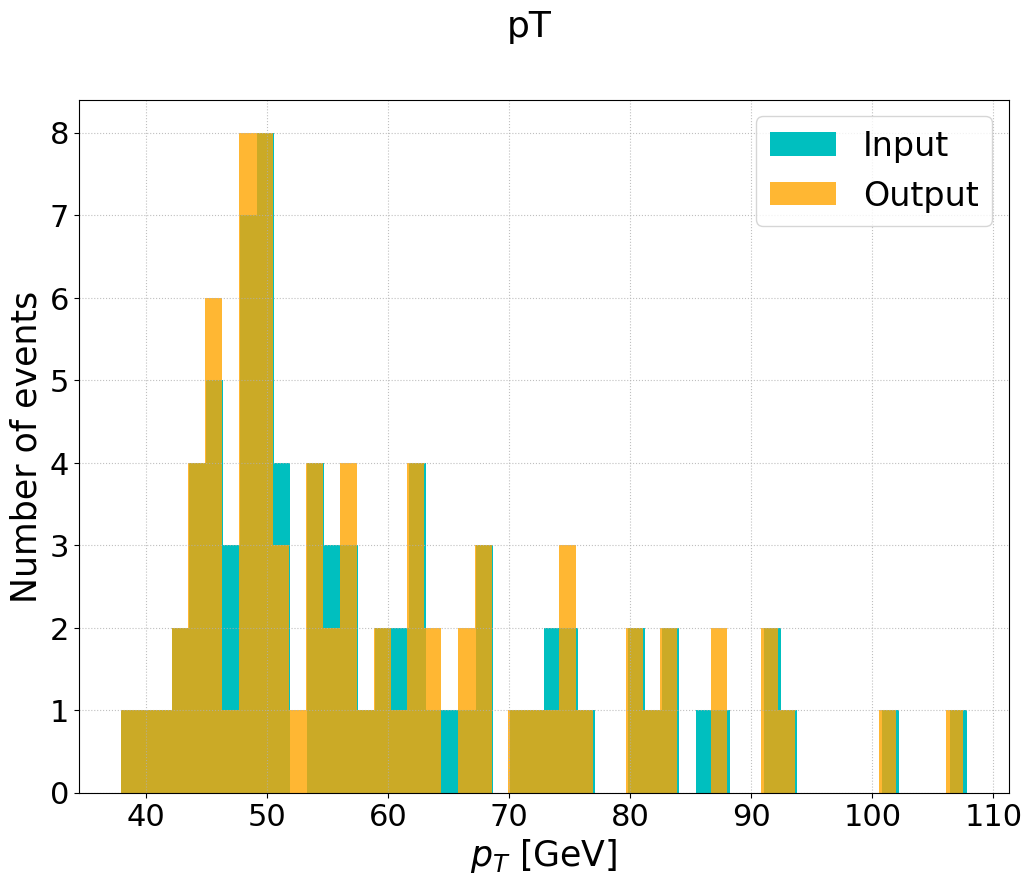

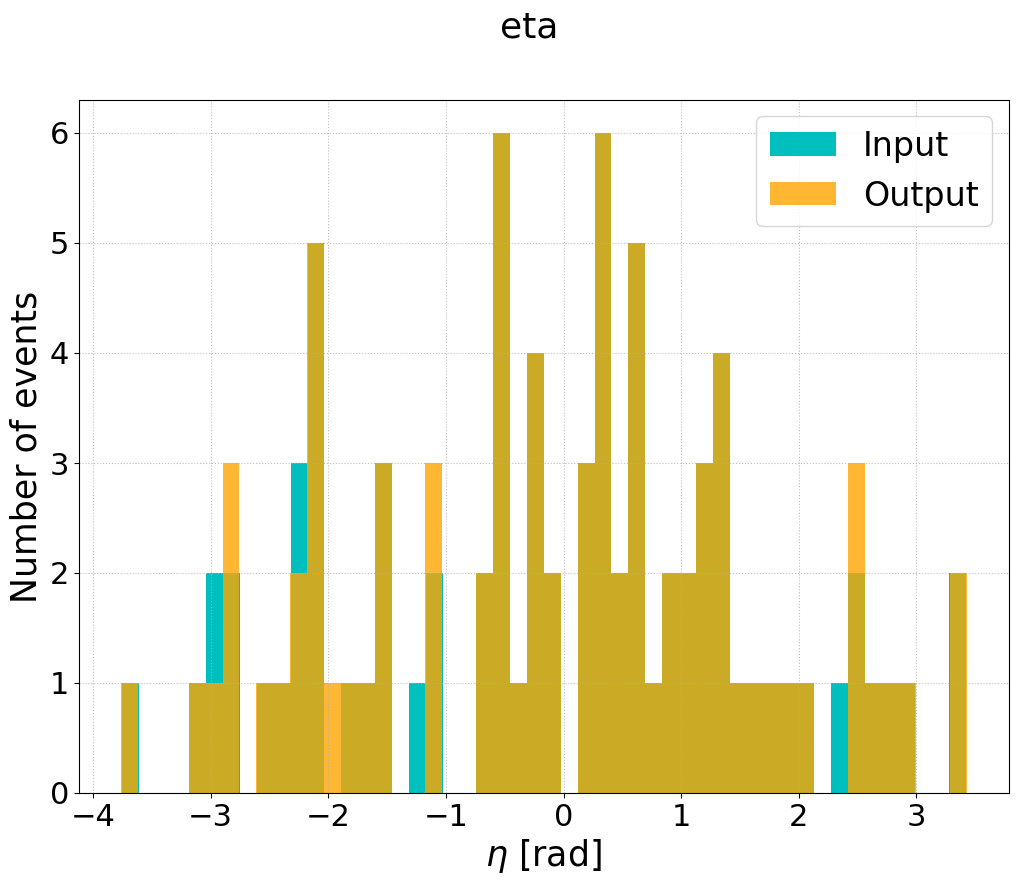

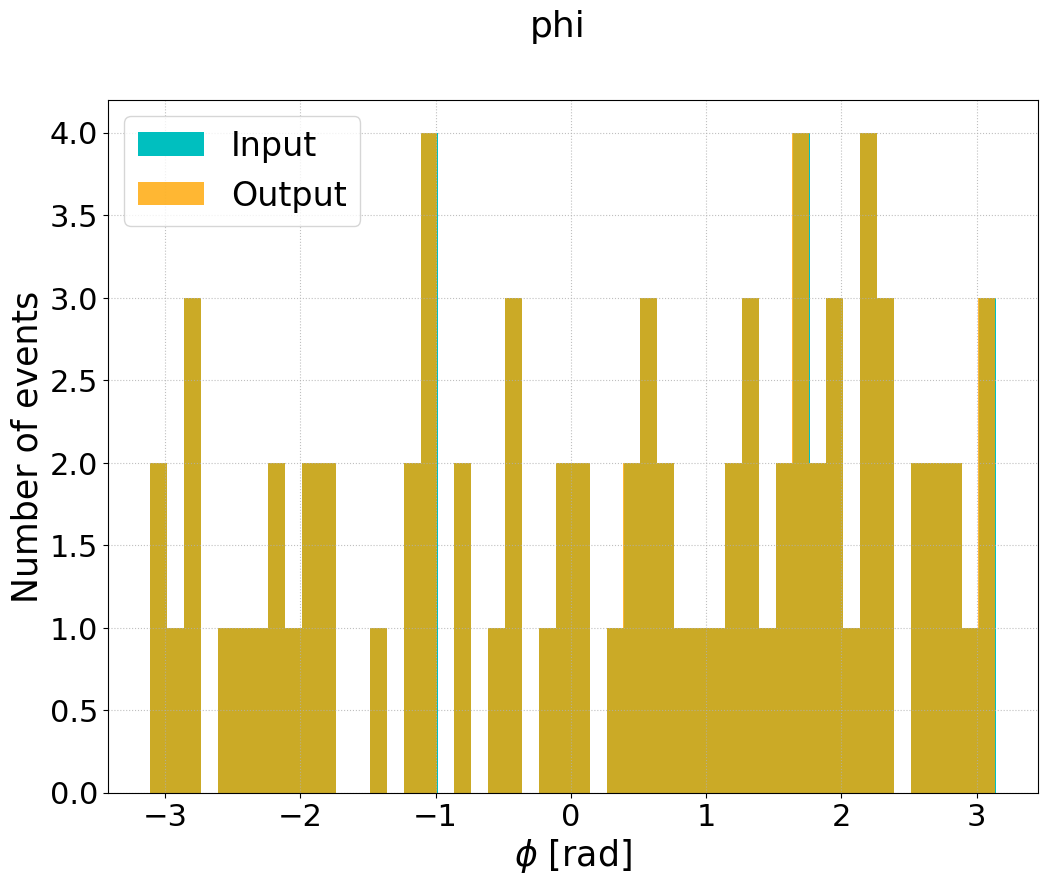

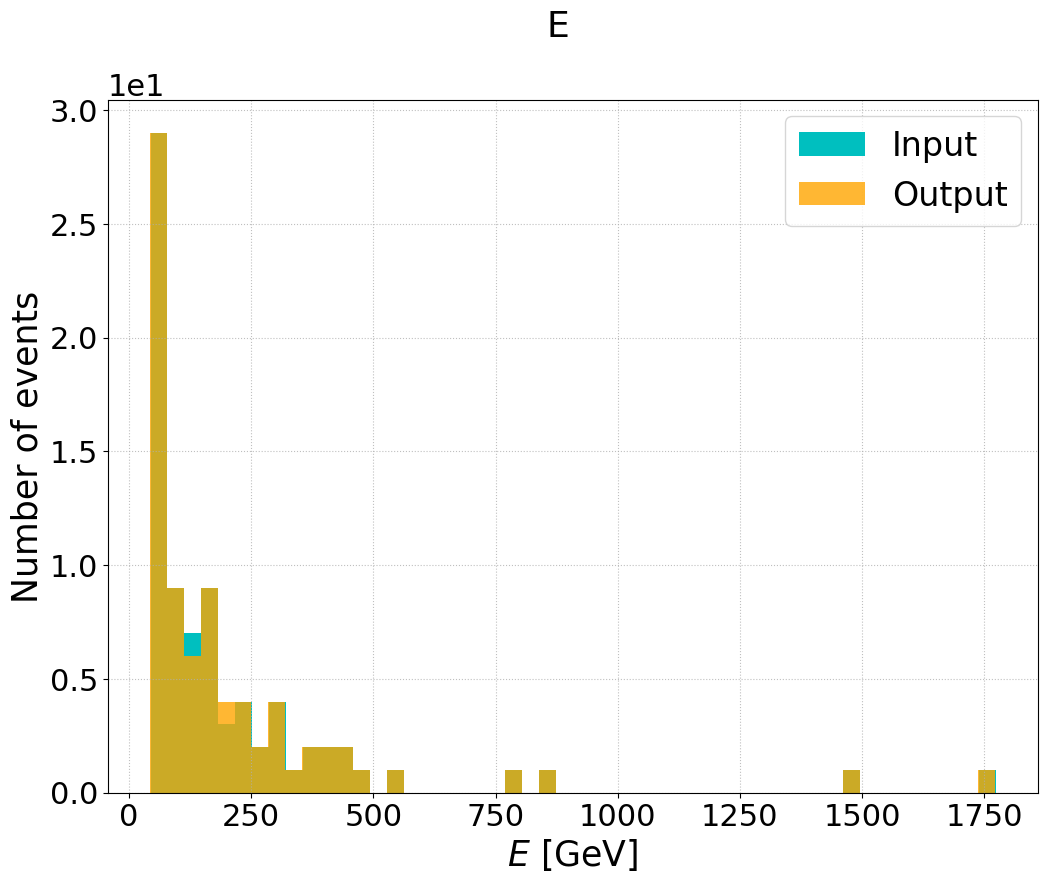

In [55]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
data = torch.tensor(train_x.values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=n_bins)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    plt.legend()

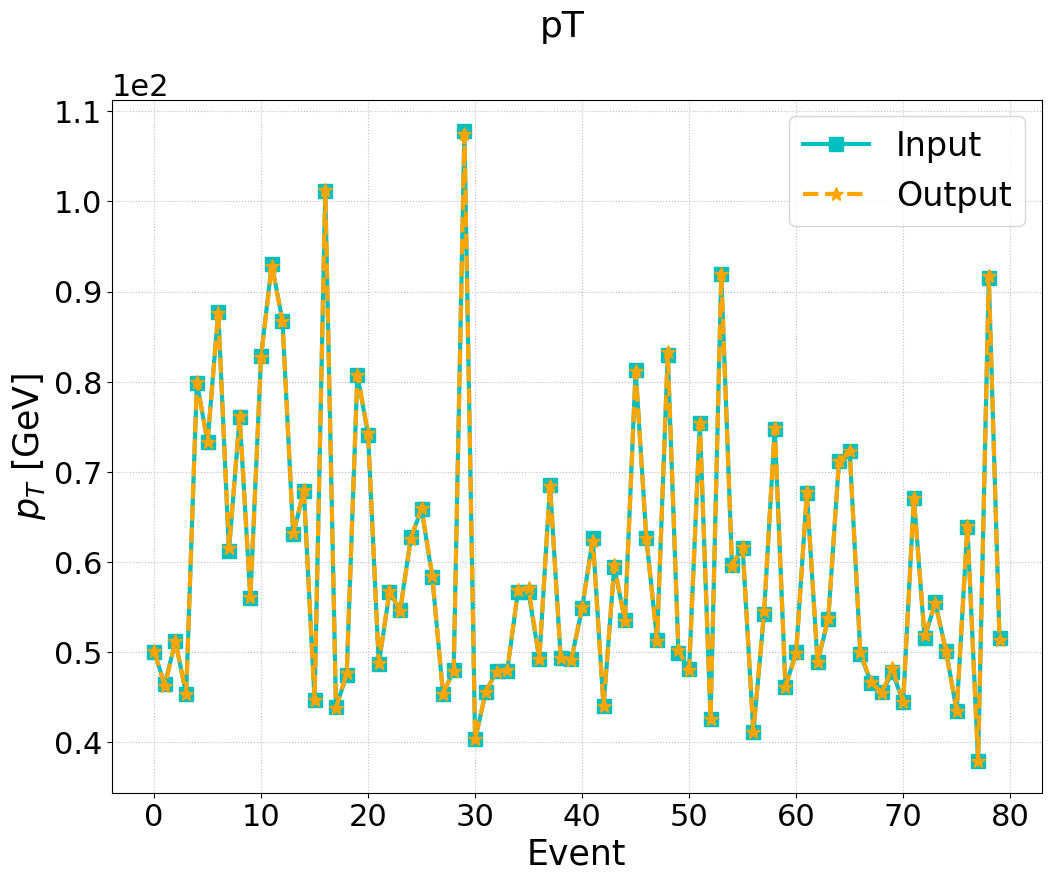

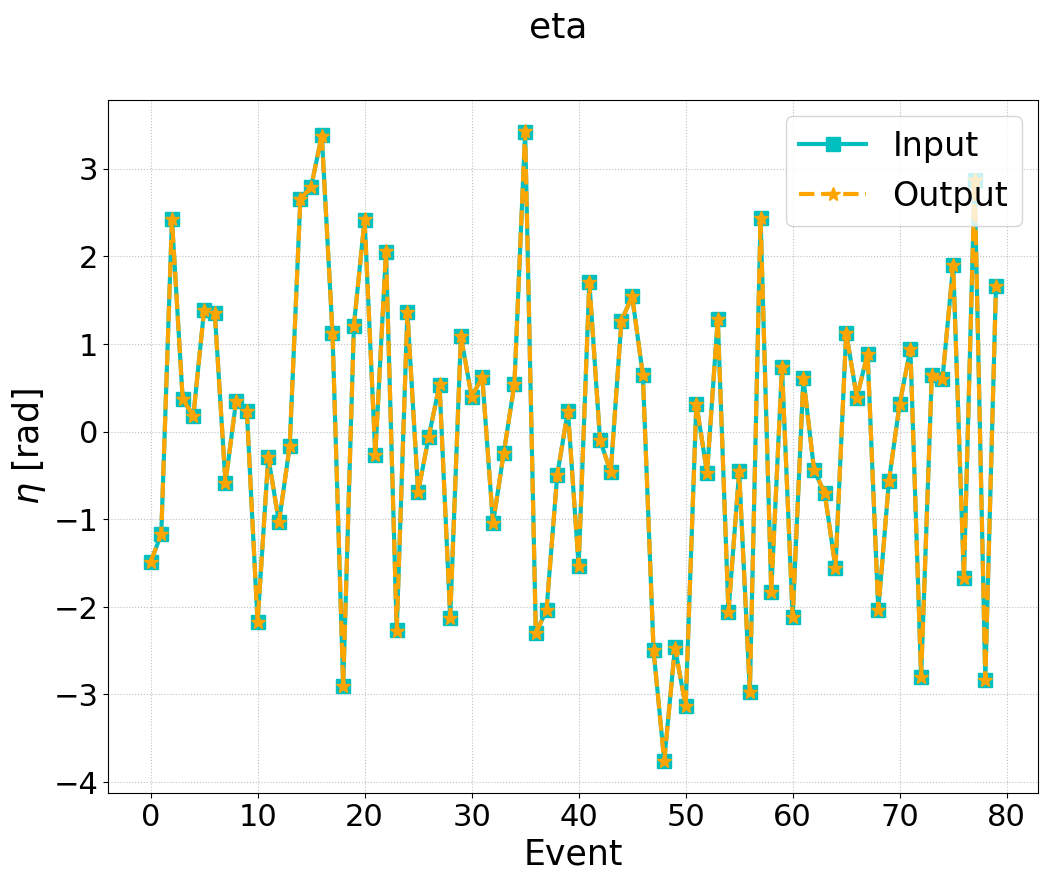

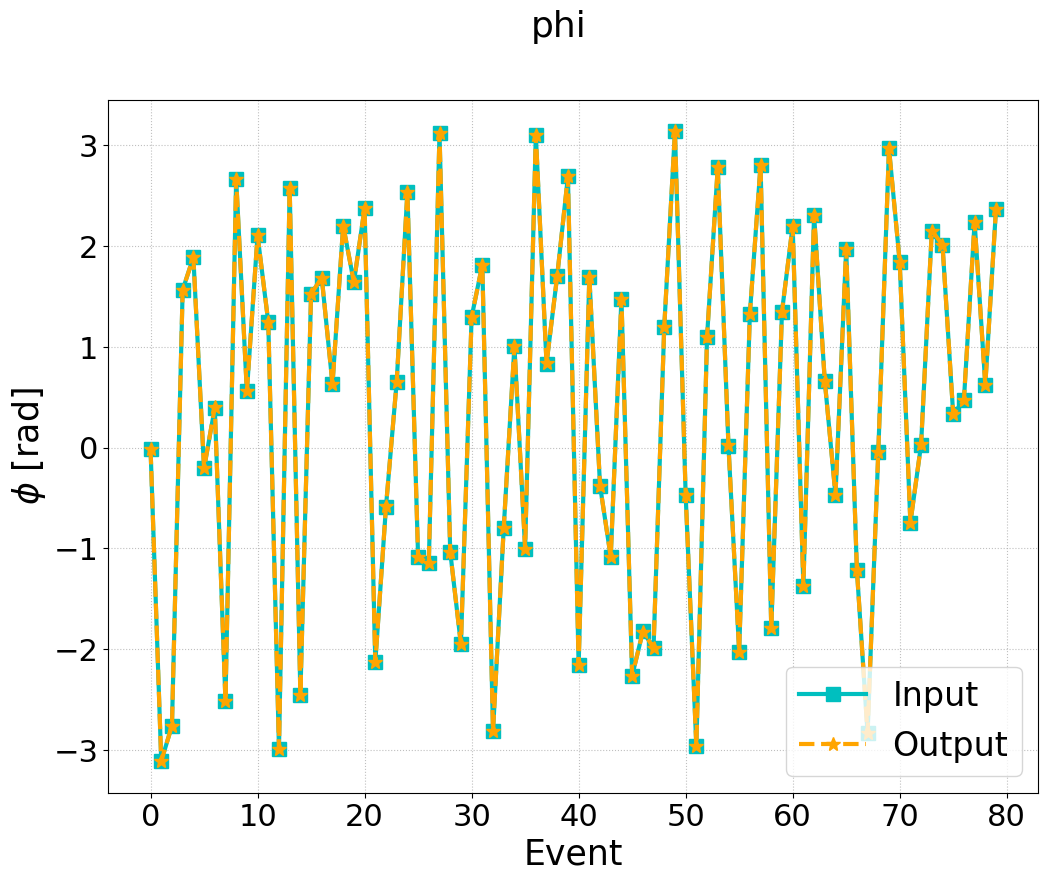

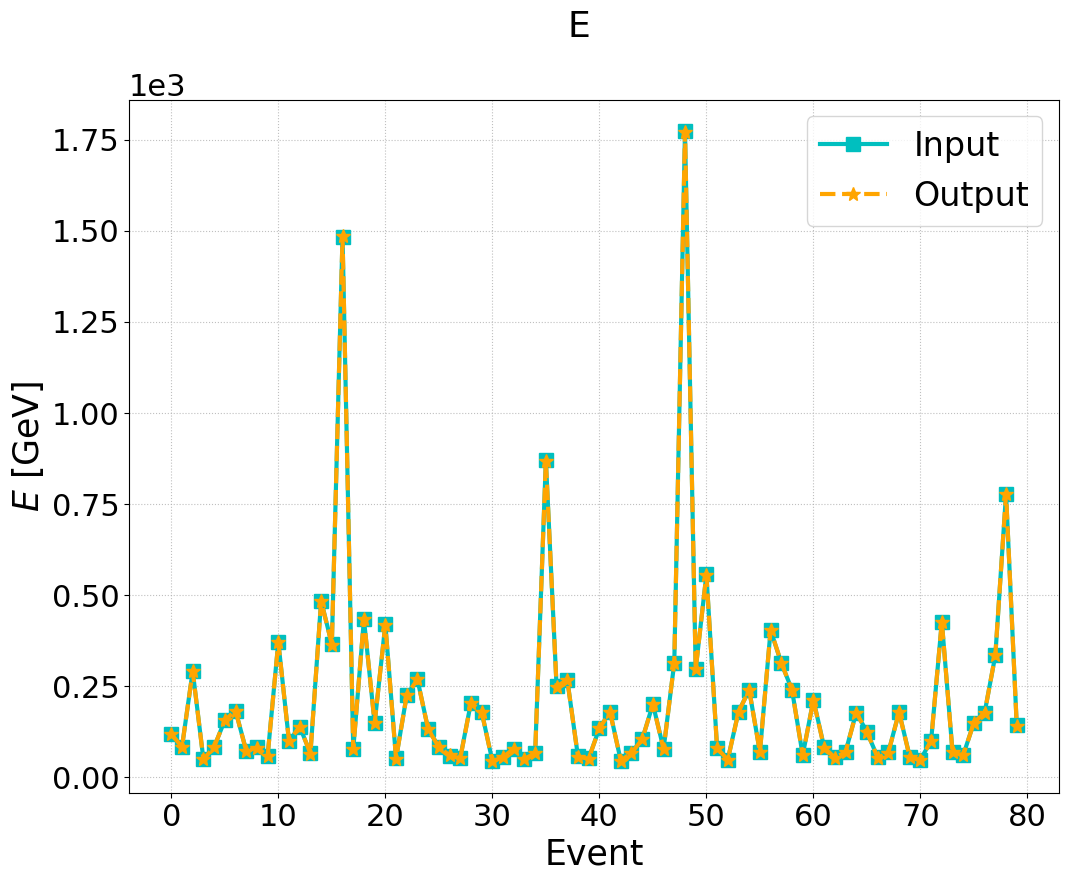

In [56]:
# Plot input on top of output
data = torch.tensor(train_x.values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [15]:
# Plot input on top of output
data = torch.tensor(train_x.values)
latent = model.encode(data).detach().numpy()

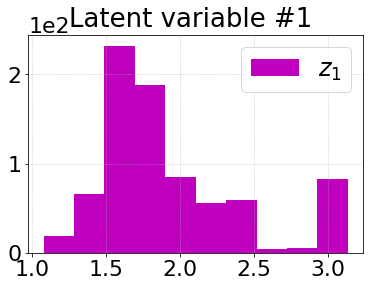

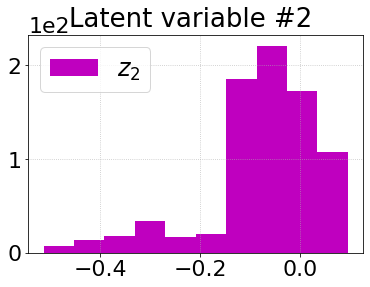

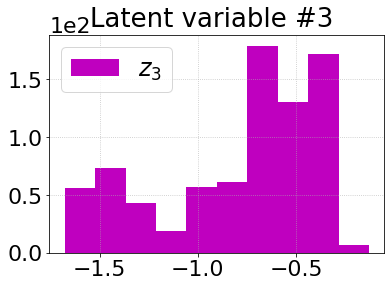

In [16]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m')
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()

Text(0.5, 0, '$z_3$')

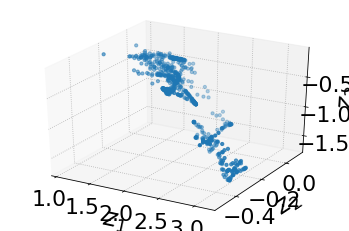

In [17]:
from mpl_toolkits.mplot3d import Axes3D

data = torch.tensor(train_x.values)
latent = model.encode(data).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2], s=10)
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel(r'$z_3$')

Text(0, 0.5, '$z_3$')

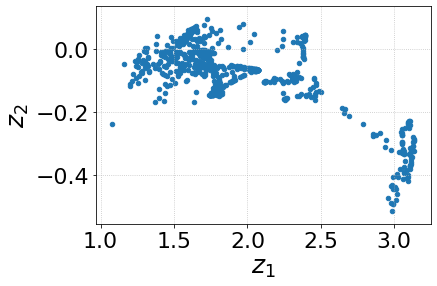

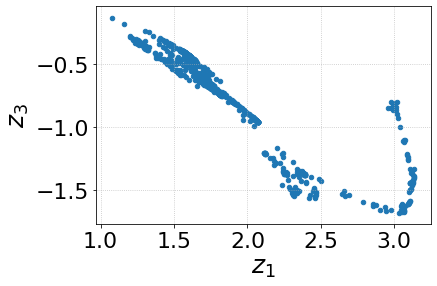

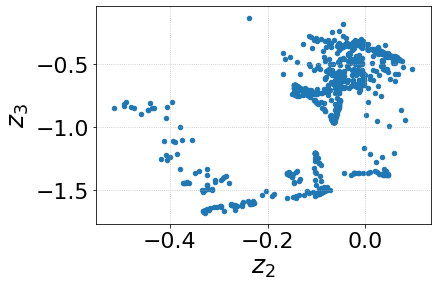

In [18]:
mksz = 20

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')

plt.figure()
plt.scatter(latent[:, 0], latent[:, 2], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_3$')

plt.figure()
plt.scatter(latent[:, 1], latent[:, 2], s=mksz)
plt.xlabel(r'$z_2$')
plt.ylabel(r'$z_3$')